In [1]:
import torch
from torch import nn
from prettytable import PrettyTable
from transformers import AutoModel, AutoTokenizer

max_length = 512 # truncate output to this predefined length 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42

def randomize_model(model):
    for module_ in model.named_modules(): 
        if isinstance(module_[1],(torch.nn.Linear, torch.nn.Embedding)):
            module_[1].weight.data.normal_(mean=0.0, std=model.config.initializer_range)
        elif isinstance(module_[1], torch.nn.LayerNorm):
            module_[1].bias.data.zero_()
            module_[1].weight.data.fill_(1.0)
        if isinstance(module_[1], torch.nn.Linear) and module_[1].bias is not None:
            module_[1].bias.data.zero_()
    return model

class EncoderForSequenceClassification(nn.Module):
    def __init__(self, model_name, classes, pretrained=True) -> None:
        super(EncoderForSequenceClassification, self).__init__()

        self.name = model_name + ' for Sequence Classification'

        self.encoder = AutoModel.from_pretrained(model_name)
        if not pretrained:
            self.encoder = randomize_model(self.encoder)
            self.name += ' random'

        self.task = 'classification'

        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, classes)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.encoder(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )
        
        pooled_output = self.dropout(outputs[1])
        predicts = self.classifier(pooled_output)
        predicts = nn.Softmax(dim=-1)(predicts)
        
        loss_fn = nn.CrossEntropyLoss()
        return {
            'predicts': predicts,
            'loss': loss_fn(predicts, labels) if labels is not None else None
        }

class EncoderForTokenClassification(nn.Module):
    def __init__(self, model_name, classes, pretrained=True) -> None:
        super(EncoderForTokenClassification, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.name = model_name + ' for Token Classification'

        if not pretrained:
            self.encoder = randomize_model(self.encoder)
            self.name += ' random'

        self.task = 'ner'

        self.classes = classes
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, classes)
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.encoder(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )

        logits = self.classifier(self.dropout(outputs[0]))
        predicts = nn.Softmax(dim=-1)(logits)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            seq_loss = loss_fn(logits.permute(0, 2, 1), labels)
            label_mask = attention_mask[:, 1:].float()
            loss = ((seq_loss * label_mask).sum()) / label_mask.sum()
        return {
            'labels': labels,
            'outputs': outputs[0],
            'predicts': predicts,
            'loss': loss
        }

'''class EncoderForQuestionAnswering(nn.Module):
    def __init__(self, model_name, labels, pretrained=True) -> None:
        super(EncoderForQuestionAnswering, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        if not pretrained:
            self.encoder = randomize_model(self.encoder)

        self.name = model_name + ' for Question Answering'
        self.task = 'qa'

        self.labels = labels
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, labels)
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.encoder(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )

        logits = self.qa_outputs(self.dropout(outputs[0]))
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        outputs = (start_logits, end_logits,) + outputs[2:]
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        return {
            'predicts': (start_logits, end_logits),
            'loss': total_loss
        }'''

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [2]:
from datasets import load_dataset
import pandas as pd

def loadIMDB(tokenizer, slice=100):
    raw_train, raw_test = load_dataset(
        'imdb', 
        split=[f'train[:{slice}%]', f'test[:{slice}%]']
    )
    
    def tokenize(examples):
        return tokenizer(examples['text'], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
    
    full_train_set = raw_train.map(tokenize, batched=True).shuffle(seed=seed)
    
    train_size = int(raw_train.num_rows * 0.9)
    train_set = full_train_set.select(range(train_size))
    val_set = full_train_set.select(range(train_size, full_train_set.num_rows))
    test_set = raw_test.map(tokenize, batched=True).shuffle(seed=seed)

    train_set = train_set.remove_columns(['text']).rename_column('label', 'labels')
    val_set = val_set.remove_columns(['text']).rename_column('label', 'labels')
    test_set = test_set.remove_columns(['text']).rename_column('label', 'labels')

    train_set.set_format('torch')
    val_set.set_format('torch')
    test_set.set_format('torch')
    
    return {
        'train': train_set, 
        'val': val_set, 
        'test': test_set
    }

def loadCONLL(tokenizer, slice=100):
    raw_ner_train, raw_ner_val, raw_ner_test = load_dataset(
    'conll2003',
    split=[f'train[:{slice}%]', f'validation[:{slice}%]', f'test[:{slice}%]']
    )

    tags = raw_ner_train.features['ner_tags'].feature.names

    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(examples["tokens"], return_tensors='pt', padding='max_length', max_length=75, truncation=True, is_split_into_words=True)

        labels = []
        for i, label in enumerate(examples[f"ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:  # Set the special tokens to -100.
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)

        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    tokenized_ner_train = raw_ner_train.map(tokenize_and_align_labels, batched=True).remove_columns(['id', 'pos_tags', 'chunk_tags', 'ner_tags', 'tokens'])
    tokenized_ner_val = raw_ner_val.map(tokenize_and_align_labels, batched=True).remove_columns(['id', 'pos_tags', 'chunk_tags', 'ner_tags', 'tokens'])
    tokenized_ner_test = raw_ner_test.map(tokenize_and_align_labels, batched=True).remove_columns(['id', 'pos_tags', 'chunk_tags', 'ner_tags', 'tokens'])

    tokenized_ner_train.set_format('torch')
    tokenized_ner_val.set_format('torch')
    tokenized_ner_test.set_format('torch')

    return {
        'train': tokenized_ner_train, 
        'val': tokenized_ner_val,
        'test': tokenized_ner_test,
        'tags': tags
    }

In [3]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader
from transformers import get_scheduler
from tqdm import tqdm
import numpy as np
import collections
import evaluate
import logging
import os

''' MAIN VALIDATION FUNCTION'''
def evalModel(model, set, tags, metric, step, writer=None):

    predicted, true = [], []
    val_loss = []

    model.eval()
    with torch.no_grad():

        for batch in tqdm(set):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']
            outputs = model(**batch)

            vloss = outputs['loss'].item()
            val_loss.append(vloss)
        
            predict = torch.argmax(outputs['predicts'], dim=-1)
        
            true.extend(labels.to('cpu'))
            predicted.extend(predict.to('cpu'))

    predicted, labels = torch.stack(predicted), torch.stack(true)

    task = model.task

    if task == 'classification':
    
        result = metric.compute(predictions=predicted, references=labels)
        returned = (list(result.values()), np.mean(np.array(val_loss)))

        if writer is not None:
            logging.info(f'Evaluation result: {returned[0]}, loss: {returned[1]}')
            writer.add_scalar('eval/loss', returned[1], step)
            writer.add_scalar('eval/accuracy', returned[0][0], step)

    if task == 'ner':

        true_predictions = [
            [tags[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predicted, labels)
        ]
        true_labels = [
            [tags[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predicted, labels)
        ]

        results = metric.compute(predictions=true_predictions, references=true_labels)
        
        metrics = {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

        loss = np.mean(np.array(val_loss))

        if writer is not None:
            logging.info(f'Evaluation result: {metrics.items()}, loss: {loss}')
            writer.add_scalar('eval/loss', loss, step)
            writer.add_scalar('eval/f1', metrics['f1'], step)
            writer.add_scalar('eval/accuracy', metrics['accuracy'], step)
            writer.add_scalar('eval/precision', metrics['precision'], step)
            writer.add_scalar('eval/recall', metrics['recall'], step)
        
        else: print(metrics, loss)

''' MAIN TRAINING FUNCTION '''
def trainModel(
    model,
    run_name,
    num_epochs,
    train_dataset,
    train_batch_size,
    lr,
    dataset_name='unknown',
    lr_scheduler_type='linear',
    log_steps=1,
    optimizer=AdamW, 
    warmup_steps=0,
    val_dataset=None,
    val_batch_size=1,
    val_strategy='epoch',
    val_metric=None,
    tags=None,
):

    dir = f'./runs/{run_name}/'

    if not os.path.exists(dir):
        os.makedirs(dir)

    logging.basicConfig(
        level=logging.INFO,
        filename=dir+'logging.log'   
    )

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    total_steps = num_epochs * len(train_loader)
    optim = optimizer(model.parameters(), lr=lr)
    scheduler = get_scheduler(
        name=lr_scheduler_type,
        optimizer=optim,
        num_training_steps=total_steps,
        num_warmup_steps=warmup_steps
    )

    logging.info(f'Model: {model.name}, trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    logging.info(f'Learning rate: {lr}, type: {lr_scheduler_type}')
    logging.info(f'Epochs: {num_epochs}, total steps: {total_steps}')
    logging.info(f'Dataset name: {dataset_name}')
    logging.info(f'Train size: {len(train_loader)}, batch size: {train_batch_size}')

    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
        val_steps = len(train_loader) if val_strategy == 'epoch' else len(train_loader) // 2
        validation = []
        metric = val_metric
        logging.info(f'Validation size: {len(val_loader)}, batch size: {val_batch_size}')
        logging.info(f'Evaluation metric: {metric.name}')

    writer = SummaryWriter()

    model.train()
    
    progress_bar, step = tqdm(range(total_steps)), 0
    for epoch in range(num_epochs):
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs['loss']
            loss.backward()

            progress_bar.set_description(f'Epoch: {epoch}, training loss: {loss.item():0.5f}')
            writer.add_scalar('train/loss', loss.item(), step)

            if val_dataset is not None:
                if (step + 1) % val_steps == 0:
                    evalModel(model, val_loader, tags, metric, step, writer)

                    torch.save(
                        {
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optim.state_dict(),
                            'loss': loss
                        }, dir+f'{step}.pt'
                    )

                    model.train()

            optim.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

            writer.add_scalar('train/learning_rate', scheduler.get_last_lr()[0], step)
            logging.info(f'Step: {step}, \t training loss: {loss.item()}, \t learning rate: {scheduler.get_last_lr()[0]}')
            
            step += 1
            progress_bar.update(1)

    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss
        }, dir+f'{step}.pt'
    )

    return validation if val_dataset is not None else None

''' MAIN TEST FUNCTION '''
def testModel(model, set, metric, batch_size, tags=None):

    test_loader = DataLoader(set, batch_size=batch_size)
    task = model.task
    model.eval()
    
    predicted, true = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']
            outputs = model(**batch)

            predict = torch.argmax(outputs['predicts'], dim=-1)
        
            true.extend(labels.to('cpu'))
            predicted.extend(predict.to('cpu'))

    predicted, labels = torch.stack(predicted), torch.stack(true)

    if task == 'classification':
    
        result = metric.compute(predictions=predicted, references=labels)
        return result['accuracy']

    if task == 'ner':

        true_predictions = [
            [tags[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predicted, labels)
        ]
        true_labels = [
            [tags[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predicted, labels)
        ]
    
        results = metric.compute(predictions=true_predictions, references=true_labels)
        # return {
        #     "predictions": predicted, 
        #     "labels": labels,
        #     "precision": results["overall_precision"],
        #     "recall": results["overall_recall"],
        #     "f1": results["overall_f1"],
        #     "accuracy": results["overall_accuracy"],
        # }
        return results['overall_f1']

In [4]:
import evaluate
from transformers import AutoTokenizer

class Training():
    def __init__(
        self, 
        model,
        task,
        classes,
        slice=100,
        pretrained=True
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        
        if task == 'classification':
            self.model = EncoderForSequenceClassification(model, classes, pretrained=pretrained).to(device)
            self.datasets = loadIMDB(self.tokenizer, slice)
            self.dataset = 'imdb'
            self.tags = None
            self.metric = evaluate.load('accuracy')

        if task == 'ner':
            self.model = EncoderForTokenClassification(model, classes, pretrained=pretrained).to(device)
            self.datasets = loadCONLL(self.tokenizer, slice)
            self.dataset = 'conll2003'
            self.tags = self.datasets['tags']
            self.metric = evaluate.load('seqeval')
        
        self.run_name = self.dataset + '/' + model

        if not pretrained:
            self.run_name += '_random'

model_name = [
    'albert-base-v2',
    'prajjwal1/bert-small',
    'sentence-transformers/all-MiniLM-L6-v2'
][2]

training = Training(
    model_name,
    task='ner',
    classes=9,
    pretrained=True
)

print(training.run_name)

Found cached dataset conll2003 (C:/Users/Даниил/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Даниил\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98\cache-49cb3c223f482c1b.arrow
Loading cached processed dataset at C:\Users\Даниил\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98\cache-25780f90c0df8c98.arrow
Loading cached processed dataset at C:\Users\Даниил\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98\cache-1eb2b61c3300006e.arrow


conll2003/sentence-transformers/all-MiniLM-L6-v2


In [5]:
trainModel(
    model=training.model,
    run_name=training.run_name,
    train_dataset=training.datasets['train'],
    val_dataset=training.datasets['val'],
    dataset_name=training.dataset,
    val_metric=training.metric,
    tags=training.tags,
    train_batch_size=128,
    val_batch_size=32,
    num_epochs=3,
    lr=5e-4,
)

testModel(
    model=training.model,
    set=training.datasets['test'],
    batch_size=32,
    metric=training.metric,
    tags=training.tags
)

Epoch: 2, training loss: 0.01569: 100%|██████████| 330/330 [01:57<00:00,  2.82it/s]


[]

In [6]:
def get_data(dir):
    train_loss = []
    with open(dir, encoding='utf-8', errors='ignore') as file:
        for line in file:
            start, end = line.find('training loss: ')+15, line.find('learning rate:')-15
            if start > 15: train_loss.append(float(line[start:end]))
    return train_loss

In [7]:
base = 'runs/conll2003/prajjwal1/bert-small/logging.log'
random = 'runs/conll2003/prajjwal1/bert-small_random/logging.log'

In [8]:
base = 'runs/conll2003/sentence-transformers/all-MiniLM-L6-v2/logging.log'
random = 'runs/conll2003/sentence-transformers/all-MiniLM-L6-v2_random/logging.log'

In [9]:
base_data = get_data(base)
random_data = get_data(random)

In [10]:
base_data = base_data[-330:]

In [11]:
len(base_data)

330

In [12]:
len(random_data)

330

In [13]:
import numpy as np

training_loss = [
    np.array([np.array([i, loss], dtype=np.float32) for i, loss in enumerate(base_data) if i % 50 == 0]),
    np.array([np.array([i, loss], dtype=np.float32) for i, loss in enumerate(random_data) if i % 50 == 0])
]

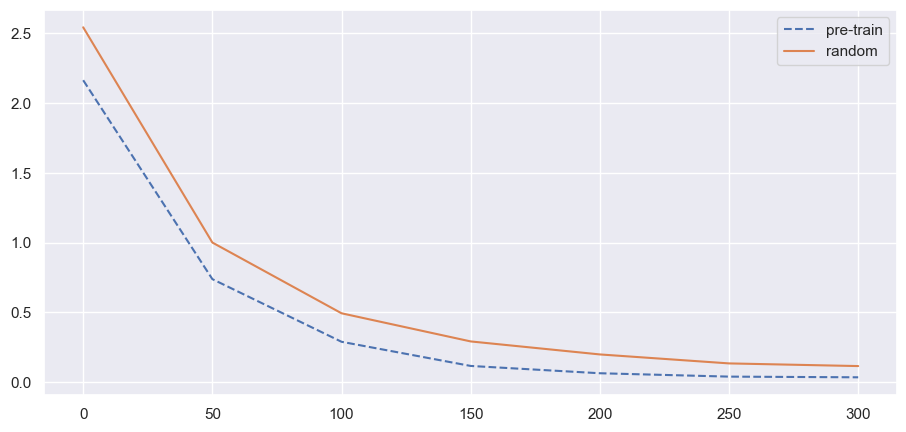

In [14]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew1 = np.linspace(training_loss[0][:,0].min(), training_loss[0][:,0].max(), 100)
xnew2 = np.linspace(training_loss[1][:,0].min(), training_loss[1][:,0].max(), 100)

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

import seaborn as sns
sns.set(rc={'figure.figsize':(11,5)})

plt.plot(
    training_loss[0][:,0],
    smooth(training_loss[0][:,1], .3),
    '--',
    label='pre-train'
)
plt.plot(
    training_loss[1][:,0],
    smooth(training_loss[1][:,1], .3),
    label='random'
)

plt.legend()